In [1]:
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
dfi = pd.read_csv("predict_intentions.csv").drop_duplicates()
dfi

,execution_id,nullify,cardinality,missing_values,not_missing_values,test_size,cardinality_acc
0,Cimice-119-0,0.0,274,100,174,20,0.072993
1,Cimice-119-1,0.0,411,151,260,20,0.048662
2,Cimice-119-0,0.0,137,50,87,20,0.145985
3,Cimice-119-1,0.0,274,100,174,20,0.072993
4,Cimice-119-2,0.0,411,151,260,20,0.048662
5,Cimice-117-0,0.0,137,50,87,20,0.145985
6,Cimice-117-1,0.0,137,50,87,20,0.145985
7,Cimice-117-2,0.0,137,50,87,20,0.145985
8,Cimice-117-3,0.0,137,50,87,20,0.145985
9,Cimice-200-0,0.0,137,50,87,20,0.145985


In [2]:
duplicated_values = dfi[dfi['execution_id'].duplicated(keep=False)]['execution_id'].unique()
print("Duplicated values:", duplicated_values)
dfi[dfi['execution_id'].isin(duplicated_values)]

Duplicated values: ['Cimice-119-0' 'Cimice-119-1']


,execution_id,nullify,cardinality,missing_values,not_missing_values,test_size,cardinality_acc
0,Cimice-119-0,0.0,274,100,174,20,0.072993
1,Cimice-119-1,0.0,411,151,260,20,0.048662
2,Cimice-119-0,0.0,137,50,87,20,0.145985
3,Cimice-119-1,0.0,274,100,174,20,0.072993


In [3]:
dfm = pd.read_csv("predict_models.csv")
dfm

,execution_id,model,time
0,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0,pivot,27
1,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0,univariateTS,829698
2,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0,multivariateTS,196253
3,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0,timeDecisionTree,342019
4,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0,timeRandomForest,354649
...,...,...,...
596,Cimice-119-0,multivariateTS,22415
597,Cimice-119-0,timeDecisionTree,1553
598,Cimice-119-0,timeRandomForest,2029
599,Cimice-119-0,decisionTree,219


In [4]:
dfc = pd.read_csv("predict_components.csv")
dfc["success_time"] = dfc.apply(lambda x: x["success_time"] if x["success_time"] > 0 else x["component_time"], axis=1)
dfc["component_time"] = dfc.apply(lambda x: ((x["success_time"] / x["success"]) * 21) if x["success"] > 0 else float('inf'), axis=1).astype(float)
dfc[dfc["model"] == "multivariateTS"] 

,model,component,interest,sparsity,endog,exog,component_time,success,success_time,accuracy,execution_id
45,multivariateTS,ALL,-inf,-1.000000,45,90,inf,0,116,NaN,5e3c46c0-aad0-430e-b9ec-1e1f67a33ed0
146,multivariateTS,ALL,0.979081,0.500000,3,6,1.767150e+04,4,3366,0.979081,bc172d04-b2b5-4cff-ba2f-7e9214116877
220,multivariateTS,ALL,-inf,-1.000000,45,90,inf,0,116,NaN,56e62a89-e814-4f1c-aba3-6a2d31e7d6d3
321,multivariateTS,ALL,0.979081,0.500000,3,6,2.117325e+04,4,4033,0.979081,ad5671dd-58af-4330-a7c7-2c85c5713103
408,multivariateTS,ALL,-1.369326,0.041096,6,0,1.901051e+05,8,72421,-1.369326,I-122-6-4
428,multivariateTS,ALL,-1.696836,0.041096,5,0,3.549192e+05,12,202811,-1.696836,I-122-5-3
445,multivariateTS,ALL,-0.831785,0.041096,4,0,8.745800e+04,9,37482,-0.831785,I-122-4-2
459,multivariateTS,ALL,-1.513014,0.041096,3,0,6.495300e+04,12,37116,-1.513014,I-122-3-1
470,multivariateTS,ALL,-0.089233,0.041096,2,0,1.834827e+04,11,9611,-0.089233,I-122-2-0
816,multivariateTS,ALL,-1.369326,0.041096,6,0,1.905750e+05,8,72600,-1.369326,I-122-6-4




 MAX STD: 0.3540088790555552





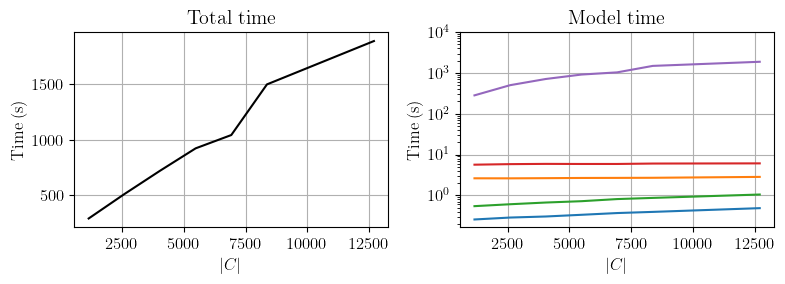

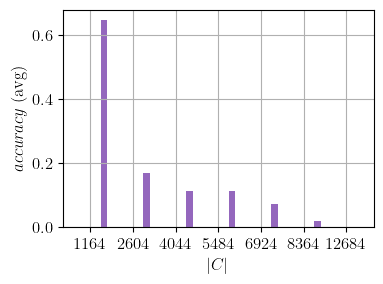

In [5]:
import shutil
import matplotlib
from matplotlib.ticker import MaxNLocator


def plot(s, title=""):
    if len(title) == 0: title = s
    filtered = dfc[dfc['execution_id'].str.contains(s)] #  & dfc['model'].isin(values_to_check) 
    values_to_check = filtered["model"].unique()        # ["timeDecisionTree", "timeRandomForest", "univariateTS", "decisionTree", "randomForest", "multivariateTS"] 
    filtered = filtered.merge(dfi, on=["execution_id"])
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-122-")) & (filtered['model'] == "multivariateTS") & (filtered['cardinality'] > 400)].index)
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-120-")) & (filtered['cardinality'] > 14000)].index)
    filtered["cardinality"] = filtered["cardinality"].astype(int)
    filtered["Predicted values"] = (filtered["cardinality"] * 0.05).astype(int)
    filtered["component_time"] = filtered["component_time"].astype(int) / 1000
    filtered = filtered.rename({"cardinality": "$|C|$", "component_time": "Time (s)", "interest": "Interest", "model": "Model"}, axis=1)
    # print(filtered)
    x = "$|C|$"
    if '-116-' in s or '-117-' in s or '-200-' in s:
        filtered["$|In|$"] = filtered['execution_id'].apply(lambda s: int(s.split('-')[-1]) + 1).astype(int)
        x = "$|In|$"
    elif '-202-' in s:
        x = "Time span"
        filtered["Time span"] = filtered["$|C|$"].apply(lambda x: '1 year' if x == 33 else ('2 years' if x == 86 else ('3 years' if x == 136 else None)))  # filtered['test_size'].apply(lambda s: f"{int(s)}\%")
    if '-200-' in s:
        x = "$p$"
        filtered[x] = filtered["$|In|$"]
    df = filtered
    def color_mapper(m):
        if m in ["decisionTree", "dT"]:
            return 'tab:blue'
        elif m in ["timeDecisionTree", "timeDT"]:
            return 'tab:orange'
        elif m in ["randomForest", "rF"]:
            return 'tab:green'
        elif m in ["timeRandomForest", "timeRF"]:
            return 'tab:red'
        elif m == "univariateTS":
            return 'tab:purple'
        elif m == "multivariateTS":
            return 'tab:brown'
        else:
            print(m)
    
    fig, axs = plt.subplots(1, 2, figsize=(8 * 1, 3 * 1)) #, sharey=True 
    axs = axs.flatten()
    i = 0
    ax = axs[i + 1] 
    var, agg = "accuracy", "mean" # "Interest", "max" # 
    df["Interest"] = df["Interest"].apply(lambda x: max(0, x))
    df["Interest2"] = df["Interest"]
    df["accuracy"] = df["accuracy"].apply(lambda x: max(0, x))
    df["accuracy2"] = df["accuracy"]    
    dff = df \
            .groupby(["execution_id", "Model", "component", "$|C|$"] + ([x] if '-202-' in s else []) + ([x] if '-116-' in s or '-117-' in s or '-200-' in s else [])) \
            .median() \
            .reset_index() \
            .groupby(["Model", x]) \
            .agg({"Time (s)": "sum", var: agg, f"{var}2": "std"})
    
    dff = dff.reset_index()
    print(f"\n\n MAX STD: {dff[f'{var}2'].max()}\n\n")
    models = sorted(dff["Model"].unique())
    if "$|In|$" in dff.columns:
        dff["$|In|$"] = dff["$|In|$"].astype(int) 
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for model in models:
        dff[dff["Model"] == model].plot(x=x, y="Time (s)", kind="line", ax=ax, label=model, c=color_mapper(model), legend=False) 
    ax.set_yscale('log')

    c, p = 1, 0
    while dff["Time (s)"].max() > c:
        c *= 10
        p += 1
    ax.set_yticks([10 ** x for x in range(0, p+1)])
    ax.set_title("Model time")
    ax.set_ylabel('Time (s)')
    ax.grid()
    fig2, ax2 = plt.subplots(1, 1, figsize=(4, 3))

    pdf = dff \
        .pivot(index=x, columns="Model", values=var) \
        .clip(lower=0)
    # print(pdf)
    
    colors = [color_mapper(col) for col in pdf.columns]
    pdf.plot(kind='bar', ax=ax2, legend=False, color=colors, rot=0, width=0.8)  # , yerr=[0.1, 0.6, 0.1]
    legend = ax2.legend(bbox_to_anchor=(0.0, 1.2), ncol=3, loc=2, borderaxespad=0., fontsize=10)
    ax2.set_ylabel("$" + var + "$ (avg)")
    legend.remove()
    ax2.grid()
    fig2.tight_layout()
    fig2.savefig(f"{title}-col.svg")
    fig2.savefig(f"{title}-col.pdf")

    dff.pivot(index="Model", columns=x, values="Time (s)").to_latex(title + "-model-time.tex", float_format="{:.2f}".format)
    print("")
    dff.pivot(index="Model", columns=x, values=var).to_latex(title + "-model-int.tex", float_format="{:.2f}".format)

    ax = axs[i]
    dff = dff.groupby([x]).agg({"Time (s)": "sum", var: agg})
    dff = dff.reset_index()
    if "$|In|$" in dff.columns:
        dff["$|In|$"] = dff["$|In|$"].astype(int) 
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    dff["Intention"] = range(0, len(dff))
    dff["Intention"] = "I" + dff["Intention"].astype(str)
    dff.index = dff["Intention"]
    dff = dff.drop("Intention", axis=1)
    if "-122-" not in s:
        dff.plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")
    else: 
        dff[dff["$|C|$"] < 400].plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")
        dff[dff["$|C|$"] > 400].plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")

    ax.set_title("Total time")
    ax.set_ylabel('Time (s)')
    ax.grid()
    fig.tight_layout()
    fig.savefig(f"{title}.svg")
    fig.savefig(f"{title}.pdf")
    dff.transpose().to_latex(title + "-overall.tex", float_format="{:.2f}".format)

try:
    plot('-120-', title="scal-time")
except:
    print()



 MAX STD: 0.4315118583889837





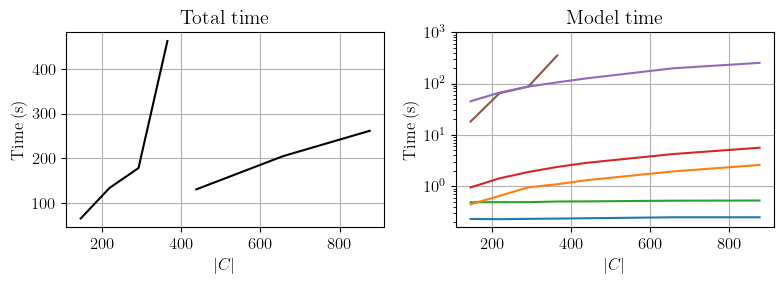

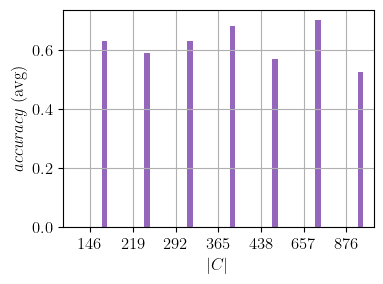

In [6]:
try:
    plot('-122-', title="scal-slices")
except:
    print()



 MAX STD: nan





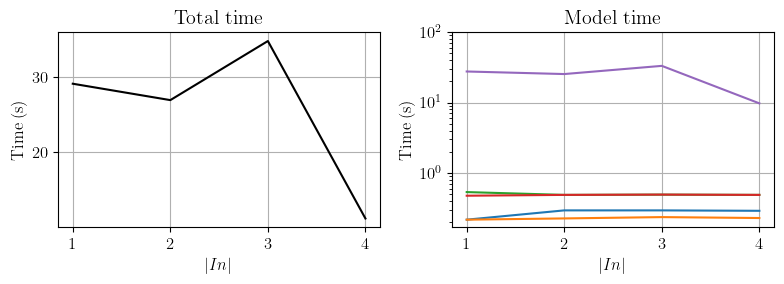

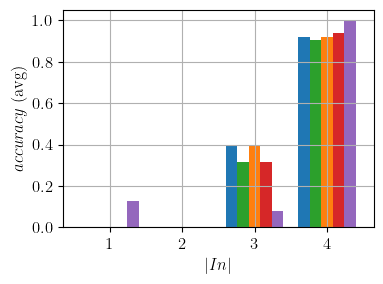

In [7]:
try: 
    plot('-117-', title="eff-in")
except:
    print()



 MAX STD: nan





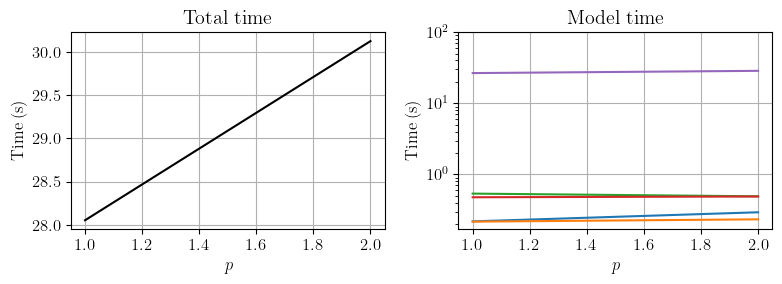

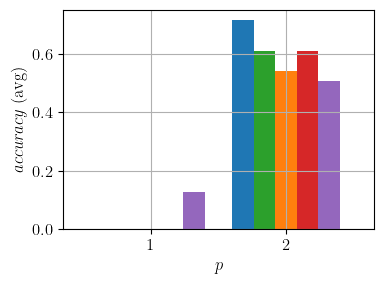

In [8]:
try:
    plot('-200-', title="eff-extknow")
except:
    print()



 MAX STD: nan





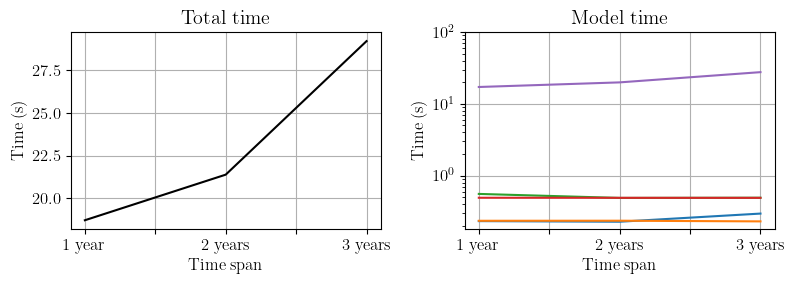

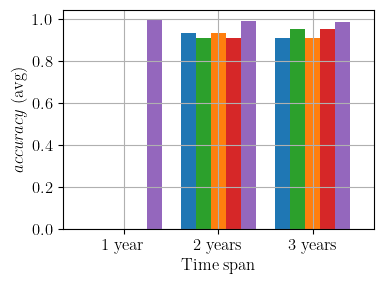

In [9]:
try:
    plot('-202-', title="eff-horizon")
except:
    print()



 MAX STD: 0.5312998843291471





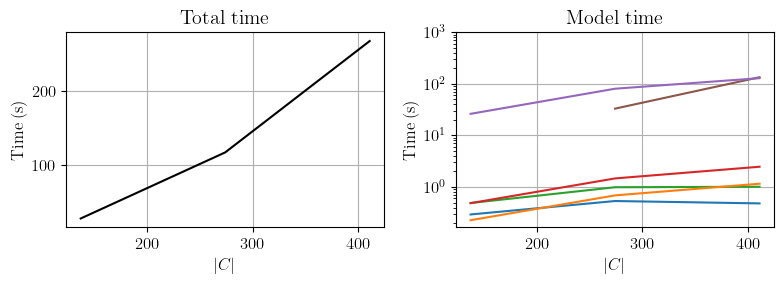

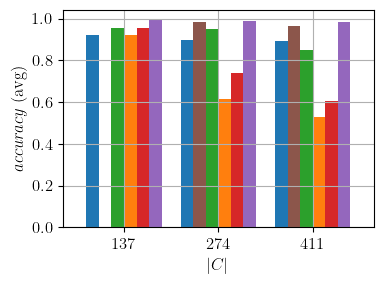

In [10]:
try:
    plot('-119-', title="eff-slices")
except:
    print()

nan
\begin{tabular}{rr}
\toprule
component_time & max \\
\midrule
0.100000 & 0.000000 \\
0.225000 & 0.926296 \\
0.485000 & 0.958126 \\
0.536000 & 0.958618 \\
24.408000 & 0.979472 \\
26.157000 & 0.992724 \\
\bottomrule
\end{tabular}



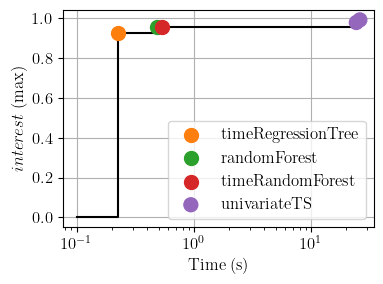

In [15]:
filtered = dfc[dfc['execution_id'].str.contains("119")] #  & dfc['model'].isin(values_to_check) 
values_to_check = filtered["model"].unique()        # ["timeDecisionTree", "timeRandomForest", "univariateTS", "decisionTree", "randomForest", "multivariateTS"] 
filtered = filtered.merge(dfi, on=["execution_id"])
filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-122-")) & (filtered['model'] == "multivariateTS") & (filtered['cardinality'] > 400)].index)
filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-120-")) & (filtered['cardinality'] > 14000)].index)
filtered["model"] = filtered["model"].apply(lambda x: x.replace("Decision", "Regression"))
filtered["cardinality"] = filtered["cardinality"].astype(int)
filtered["Predicted values"] = (filtered["cardinality"] * 0.05).astype(int)
filtered["component_time"] = filtered["component_time"].astype(int) / 1000
filtered = filtered[filtered['cardinality'] == 274] #  & dfc['model'].isin(values_to_check) 
filtered = filtered.sort_values("component_time")
# filtered = filtered[["component_time", "interest"]].groupby("component_time").max().reset_index()
filtered["max"] = filtered["interest"].cummax() #.rolling(window=2).max().reset_index(drop=True).rolling(window=2).max().reset_index(drop=True)
filtered[["component_time", "max", "model"]].reset_index(drop=True)
fig,ax = plt.subplots(1, 1, figsize=(4, 3))
filtered = filtered.dropna().reset_index(drop=True)
filtered = pd.concat([pd.DataFrame([[0.1, 0]], columns=["component_time", "max"]), filtered])
filtered = filtered[filtered['max'] != filtered['max'].shift()].reset_index(drop=True)
filtered.iloc[3, filtered.columns.get_loc('component_time')] += + 0.05
def color_mapper(m):
    if m in ["decisionTree", "dT"]:
        return 'tab:blue'
    elif m in ["timeDecisionTree", "timeDT", "timeRegressionTree"]:
        return 'tab:orange'
    elif m in ["randomForest", "rF"]:
        return 'tab:green'
    elif m in ["timeRandomForest", "timeRF"]:
        return 'tab:red'
    elif m == "univariateTS":
        return 'tab:purple'
    elif m == "multivariateTS":
        return 'tab:brown'
    else:
        print(m)
# print(filtered)            
filtered["color"] = filtered["model"].apply(color_mapper)
# filtered.plot(x="component_time", y="max", ax=ax, legend="interest")
ax.set_xscale('log')
ax.grid()
for x in filtered["model"].unique():
    ffiltered = filtered[filtered["model"] == x]
    if len(ffiltered) > 0 and x != "nan":
        ax.scatter(ffiltered['component_time'], ffiltered['interest'], color=ffiltered['color'], s=100, zorder=5, label=x)
ax.step(filtered['component_time'], filtered['max'], where='post', marker=None, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel("$interest$ (max)")
ax.legend()
fig.tight_layout()
fig.savefig("intovertime.svg")
fig.savefig("intovertime.pdf")
print(filtered[["component_time", "max"]].to_latex(index=False))